In [28]:
import warnings
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

warnings.filterwarnings('ignore')

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("ab_browser_test.csv") 
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите  до третьего знака после точки. 

In [4]:
df_exp = df[df['slot'] == 'exp']
df_control = df[df['slot'] == 'control']


In [5]:
control_clicks_sum = df_control['n_clicks'].sum()
exp_clicks_sum = df_exp['n_clicks'].sum()

print(exp_clicks_sum, control_clicks_sum)

3261823 3210027


In [6]:
print(round(exp_clicks_sum/(control_clicks_sum * 0.01) - 100, 3))

1.614


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries



In [8]:
exp_clicks = df_exp['n_clicks'].values
control_clicks = df_control['n_clicks'].values
print(control_clicks)

[12  4 22 ...  1  0  2]


In [9]:
np.random.seed(0)


exp_clicks_median_scores = list(map(np.median, get_bootstrap_samples(exp_clicks, 1000)))
control_clicks_median_scores = list(map(np.median, get_bootstrap_samples(control_clicks, 1000)))


In [10]:
print("95% confidence interval for the ILEC median repair time:",  stat_intervals(exp_clicks_median_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(control_clicks_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [5. 5.]
95% confidence interval for the CLEC median repair time: [4. 4.]


In [11]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(control_clicks_median_scores, exp_clicks_median_scores)))
print("95% confidence interval for the ILEC median repair time:",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [1. 1.]


In [12]:
exp_clicks_mean_scores = list(map(np.mean, get_bootstrap_samples(exp_clicks, 1000)))
control_clicks_mean_scores = list(map(np.mean, get_bootstrap_samples(control_clicks, 1000)))

print("95% confidence interval for the ILEC median repair time:",  stat_intervals(exp_clicks_mean_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(control_clicks_mean_scores, 0.05))

95% confidence interval for the ILEC median repair time: [11.50674915 11.65758017]
95% confidence interval for the CLEC median repair time: [11.21242374 11.35449133]


In [13]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(control_clicks_mean_scores, exp_clicks_mean_scores)))
print("95% confidence interval for the ILEC median repair time:",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [0.19866114 0.40975645]


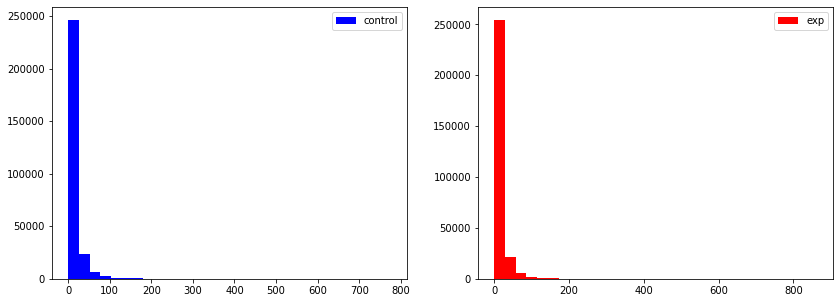

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 5))
plt.subplot(1,2,1)
plt.hist(df_exp.n_clicks, bins = 30, color = 'b', label = 'control')
plt.legend()

plt.subplot(1,2,2)
plt.hist(df_control.n_clicks, bins = 30, color = 'r', label = 'exp')
plt.legend()

plt.show()

In [17]:
np.random.seed(0) 
n_boot_samples = 500

control_bootstrap = get_bootstrap_samples(control_clicks, n_boot_samples)


In [18]:
control_mean = list(map(np.mean, control_bootstrap))


In [19]:
control_boot_chi_squared = list(map((lambda x: sum((x - control_mean)**2)), control_bootstrap.reshape(-1)))

KeyboardInterrupt: 

In [ ]:

probplot(control_boot_chi_squared, dist="chi2", sparams=(len(control_boot_chi_squared)-1), plot = plt)
probplot(control_mean, dist="chi2", sparams=(len(control_mean)-1), plot = plt)

5. Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ?

In [20]:
control_user_clicks = df_control.groupby('userID').n_clicks.sum()
exp_user_clicks = df_exp.groupby('userID').n_clicks.sum()

In [24]:
stat, p = mannwhitneyu(control_user_clicks, exp_user_clicks )
print('Statistics=%f, p=%f' % (stat, p))

Statistics=38901259929.000000, p=0.000000


6. Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с  𝛼 =0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [26]:
p_value = []
for col in list(df_control.browser.unique()):
    stat, p = mannwhitneyu(df_control[(df_control['browser'] == col) & (df_control['n_clicks'] != 0)].n_clicks, 
                           df_exp[(df_exp['browser'] == col) & (df_exp['n_clicks'] != 0)].n_clicks)
    p_value.append(p)
    
p_value

[0.16493530767704329,
 1.2219033063170227e-95,
 0.2923599574344776,
 0.4345606087024535,
 0.2908339259636146,
 0.06745842337310633]

In [29]:
_, p_adjusted, _, _ = multipletests(p_value, alpha=0.05, method='bonferroni')
list(p_adjusted)

[0.9896118460622597, 7.331419837902136e-95, 1.0, 1.0, 1.0, 0.404750540238638]

7. Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [32]:
df_exp = df[df['slot'] == 'exp']
df_control = df[df['slot'] == 'control']

querries = pd.DataFrame(columns = ['browser', 'control', 'exp'])
for i, col in enumerate(list(df.browser.unique())):
    control_nonq_click = sum(df_control[(df_control['browser'] == col)].n_nonclk_queries)
    control_q_click = sum(df_control[(df_control['browser'] == col)].n_queries)

    exp_nonq_click = sum(df_exp[(df_exp['browser'] == col)].n_nonclk_queries)
    exp_q_click = sum(df_exp[(df_exp['browser'] == col)].n_queries)
    control_q = control_nonq_click*100/control_q_click
    exp_q = exp_nonq_click*100/exp_q_click
    querries.loc[i] = [col, control_q, exp_q]

querries

,browser,control,exp
0,Browser #2,45.962747,44.982747
1,Browser #4,46.970930,45.142942
2,Browser #14,57.590411,43.755617
3,Browser #17,36.299367,36.937413
4,Browser #20,40.540485,38.977376
5,Browser #22,40.593977,39.853947
